<h5>The goal is to predict whether a customer's loan will be accepted or not,<br>
    The columns for this purpose are :-<br></h5>
    Gender - nominal<br>
    Married - nominal<br>
    Dependents - nominal<br>
    Education - nominal<br>
    Self_Employed - nominal<br>
    ApplicantIncome - continuous<br>
    CoapplicantIncome - continuous<br>
    LoanAmount - continuous<br>
    Loan_Amount_Term - continous<br>
    Credit_History - nominal<br>
    Property_Area - nominal<br>
<h5>The target variable is -</h5><br>
    Loan_Status

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel,chi2_contingency,wilcoxon,probplot,normaltest,mannwhitneyu,ranksums
from sklearn.model_selection import train_test_split
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus
from sklearn import preprocessing,tree
from sklearn.metrics import confusion_matrix,classification_report
import statsmodels.api as sm
from sklearn.feature_selection import RFE

df = pd.read_csv('./Downloads/train_ctrUa4K.csv')
test = pd.read_csv('./Downloads/test_lAUu6dG.csv')

Importing neccessary libraries and the dataset

In [114]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

NaN values are mostly in Credit history, Loan Amount, Self Employed columns. We cannot exclude all the rows/columns with NaN values, that reduces the dataset and valuable information.

In [200]:
df[df.Dependents.isnull()]
m = (df.Married == 'Yes') & (df.Dependents.isnull())
m_ = (df.Married == 'No') & (df.Dependents.isnull())
M = (df.Dependents.isnull()) & (df.CoapplicantIncome != 0)
M_ = (df.Dependents.isnull()) & (df.CoapplicantIncome == 0)
df.Dependents = df.Dependents.mask(m,1)
df.Dependents = df.Dependents.mask(m_,0)
df.Dependents = df.Dependents.mask(M,1)
df.Dependents = df.Dependents.mask(M_,0)
df.Dependents = df.Dependents.replace('3+','3').astype('int64')

Looking at the Dependents column and Married column, we can impute the null values with the logic that - <br>
1. For a Married person, the Dependents must be atleast 1 <br>
2. For a Non-Married person we can assume Dependents to be 0 <br>

Looking at the Dependents column and the Coapplicant Income column incase Married column in null, we conclude that - <br>
1. If the Co-applicant income is True (> 0) then we can assume atlease 1 Dependent <br>
2. If the Co-applicant income is False (= 0) then Dependents is 0 


In [201]:
m = (df.Married.isnull()) & (df.Dependents >= 1)
m_ = (df.Married.isnull()) & (df.Dependents == 0)
df.Married = df.Married.mask(m,'Yes')
df.Married = df.Married.mask(m_,'No')

Since we cleaned the Dependents column, we can use it to impute null values for the Married column. If the Dependents is greater than 1, We assume the person to be Married, Else Dependents are 0

In [202]:
df.Self_Employed = df.Self_Employed.fillna(df.Self_Employed.mode()[0])
df.Gender = df.Gender.fillna(df.Gender.mode()[0])
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.mode()[0])
df.Credit_History = df.Credit_History.fillna(0)

The columns Self_Employed, Gender, Loan_Amount_Term and Credit History can be assumed to be filled with the mode of the column.

In [203]:
df = df[~df.LoanAmount.isnull()]

For the rows that dont have the Loan Amount given, we can remove these from the dataset as without Loan Amount it is highly safe to assume that we cannot classify the status or impute the values via derivation through other columns.

In [204]:
df[['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status']] = df[['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status']].astype('str')

/home/hp/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [205]:
df.Loan_Status = df.Loan_Status.str.replace('N','0')
df.Loan_Status = df.Loan_Status.str.replace('Y','1')
df.Loan_Status = df.Loan_Status.astype('int64')

/home/hp/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [206]:
def encode(Sr):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(Sr)
    return encoder.transform(Sr)

for cols in ['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status']:
    df[cols] = encode(df[cols])

/home/hp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Convert the target column to Integer type for the Classifier.

NormaltestResult(statistic=78.07395238907458, pvalue=1.112901296934623e-17)


WilcoxonResult(statistic=0.0, pvalue=1.2083666526413101e-98)

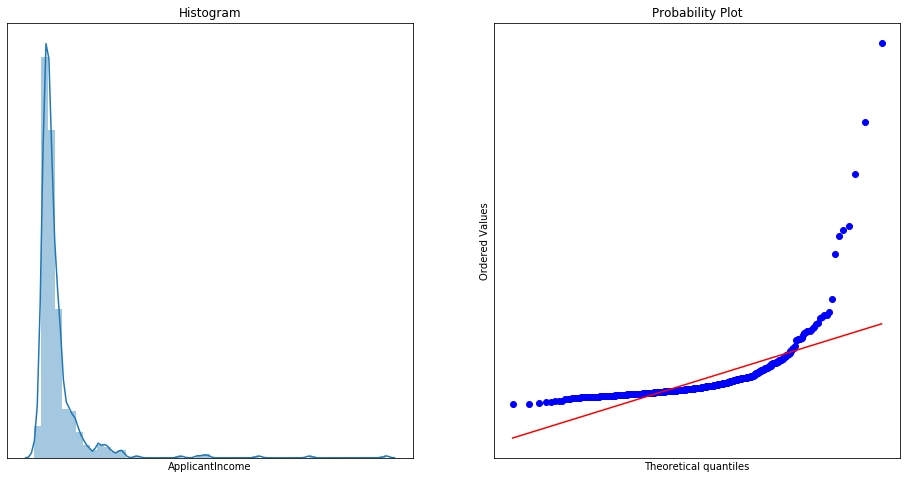

In [207]:
print(normaltest(np.log1p(df.ApplicantIncome)))
fig,ax = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax1.tick_params(top=False,left=False,right=False,bottom=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Histogram')
sns.distplot(df.ApplicantIncome)
ax2 = plt.subplot(1,2,2)
ax2.tick_params(top=False,left=False,right=False,bottom=False)
ax2.set_xticks([])
ax2.set_yticks([])
tmp = probplot(df.ApplicantIncome,plot=ax2)
wilcoxon(df.ApplicantIncome,df.Loan_Status)

We perform the Normality test for the Applicant Income column. The Null Hypothesis is that the distribution is gaussian. Since the p-value is less than 0.05 (significance level) we will reject the Null Hypothesis. The test is backed by the kde plot and the QQ plot. <br>
Thus we perform a non-parametric test on the Null Hypothesis that there is an influence of Applicant Income on the Loan Status of the Applicant. The Wilcoxon test gives the p-value very small and hence we can say with atleast 99% confidence that Applicant Income has an influence on Loan Status (Alternate Hypothesis)

NormaltestResult(statistic=831.7353740725275, pvalue=2.460131479970568e-181)


WilcoxonResult(statistic=14878.0, pvalue=1.6680787041988282e-50)

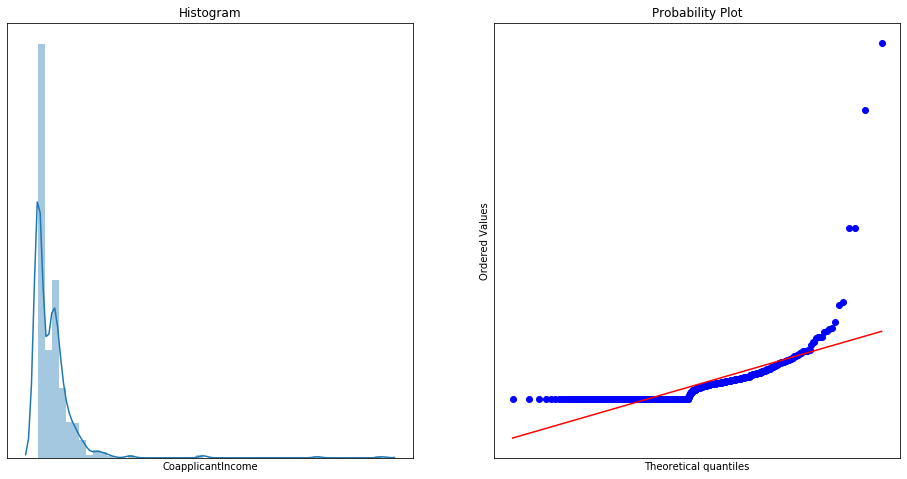

In [208]:
print(normaltest(df.CoapplicantIncome))
fig,ax = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax1.tick_params(top=False,left=False,right=False,bottom=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Histogram')
sns.distplot(df.CoapplicantIncome)
ax2 = plt.subplot(1,2,2)
ax2.tick_params(top=False,left=False,right=False,bottom=False)
ax2.set_xticks([])
ax2.set_yticks([])
tmp = probplot(df.CoapplicantIncome,plot=ax2)
wilcoxon(df.CoapplicantIncome,df.Loan_Status)

The Co-Applicant Income column doesnot follow the Normal distribution. This can be confirmed by the plots as well as the Normality test p-value. Thus we have to perform the Non-parametric test, Wilcoxon test. The results of the Wilcoxon test give a p-value lesser than 0.05, thus we can say with 99% confidence that Co-Applicant Income influences the Loan Status

WilcoxonResult(statistic=0.0, pvalue=1.105339981856861e-104)


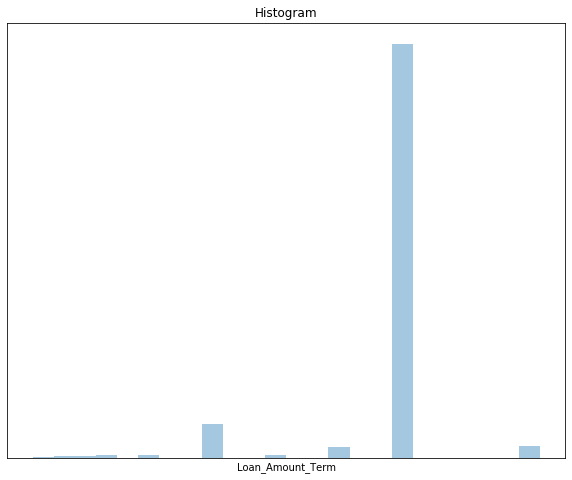

In [210]:
plt.figure(figsize=(10,8))
plt.tick_params(top=False,left=False,right=False,bottom=False)
plt.xticks([])
plt.yticks([])
plt.title('Histogram')
sns.distplot(df.Loan_Amount_Term,kde=False)
print(wilcoxon(df.Loan_Amount_Term,df.Loan_Status))

Looking at the graph, there is no distribution in the graph. Thus we go for a wilcoxon test as it is of continuous scale. The test tells us that Loan_Amount_Term is significant to Loan_Status

NormaltestResult(statistic=831.7353740725275, pvalue=2.460131479970568e-181)
WilcoxonResult(statistic=0.0, pvalue=1.2010843740167003e-98)


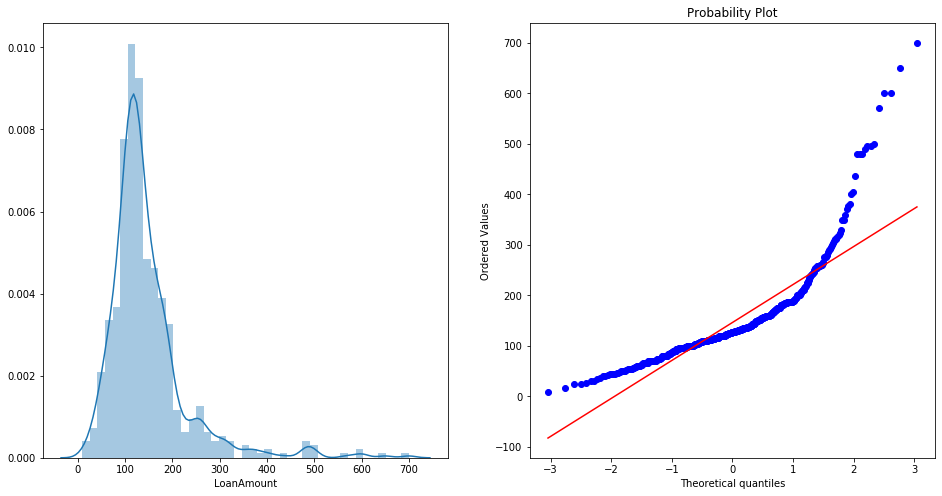

In [212]:
print(normaltest(df.CoapplicantIncome))
fig,ax = plt.subplots(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
sns.distplot(df.LoanAmount)
ax2 = plt.subplot(1,2,2)
tm = probplot(df.LoanAmount,plot=ax2)
print(wilcoxon(df.LoanAmount,df.Loan_Status))

As the normal test says it is not a Gaussian distribution, we apply the wilcoxon test

In [20]:
tb = pd.crosstab(df.Credit_History,df.Loan_Status)
chi2_contingency(tb)

(107.02920155995258,
 4.386580061382884e-25,
 1,
 array([[ 40.96959459,  93.03040541],
        [140.03040541, 317.96959459]]))

In [26]:
tb = pd.crosstab(df.Gender,df.Loan_Status)
chi2_contingency(tb)

(0.25037143304010334,
 0.6168136614066205,
 1,
 array([[ 33.32601351,  75.67398649],
        [147.67398649, 335.32601351]]))

In [27]:
tb = pd.crosstab(df.Married,df.Loan_Status)
chi2_contingency(tb)

(4.398593927231857,
 0.035968574180558474,
 1,
 array([[ 63.28885135, 143.71114865],
        [117.71114865, 267.28885135]]))

In [28]:
tb = pd.crosstab(df.Education,df.Loan_Status)
chi2_contingency(tb)

(2.7787382541808583,
 0.09552339599521484,
 1,
 array([[142.17060811, 322.82939189],
        [ 38.82939189,  88.17060811]]))

In [29]:
tb = pd.crosstab(df.Self_Employed,df.Loan_Status)
chi2_contingency(tb)

(0.008252101776950991,
 0.9276188680241723,
 1,
 array([[156.84628378, 356.15371622],
        [ 24.15371622,  54.84628378]]))

In [30]:
tb = pd.crosstab(df.Property_Area,df.Loan_Status)
chi2_contingency(tb)

(10.767206163155164,
 0.004591249445619521,
 2,
 array([[ 52.89358108, 120.10641892],
        [ 69.70945946, 158.29054054],
        [ 58.39695946, 132.60304054]]))

In [87]:
tb = pd.crosstab(df.Dependents,df.Loan_Status)
chi2_contingency(tb)

(3.158339770698263,
 0.3678506740863211,
 3,
 array([[107.12854758, 237.87145242],
        [ 31.67278798,  70.32721202],
        [ 31.36227045,  69.63772955],
        [ 15.83639399,  35.16360601]]))

For the nominal columns - Dependents, Gender, Married, Credit_History, Property_Area, Self_Employed and Education
we apply the Chi-square test for correlation of the column to the target Loan_Status

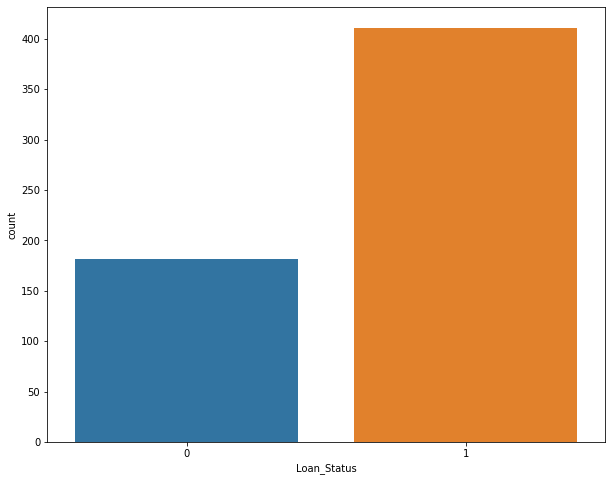

In [213]:
plt.figure(figsize=(10,8))
sns.countplot(df.Loan_Status)

In [50]:
y = df.Loan_Status
X = df.iloc[:,1:12]
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X.values))
mod = SVC(kernel='linear',gamma=0.5,C=1)
sel = RFE(mod,7,1,1).fit(X,y)
sel.support_

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


array([False, False,  True,  True, False,  True, False,  True,  True,
        True,  True])

RFE - Recursive feature estimation, recursively fits a linear model to the data. Based on the p-value of the significant tests for every coefficient, one column in eliminated.<br>
Based on that we get a mask for the columns. The columns that are significant to the target variable are,<br>
    Dependents<br>
    Education<br>
    ApplicantIncome<br>
    LoanAmount<br>
    Loan_Amount_Term<br>
    Credit_History<br>
    Property_Area

In [219]:
y = df.Loan_Status
X = df.iloc[:,1:12]
X = X.iloc[:,sel.support_]
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X.values))
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [220]:
from sklearn.svm import SVC
model = SVC(kernel='linear',gamma=0.01,C=1)
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(confusion_matrix(model.predict(X_test),y_test))
print(classification_report(y_test,model.predict(X_test)))

0.777027027027027
0.7567567567567568
[[23 11]
 [25 89]]
              precision    recall  f1-score   support

           0       0.68      0.48      0.56        48
           1       0.78      0.89      0.83       100

    accuracy                           0.76       148
   macro avg       0.73      0.68      0.70       148
weighted avg       0.75      0.76      0.74       148



In [221]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.02,max_depth=6,random_state=0)
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(confusion_matrix(y_test,model.predict(X_test)))
print(classification_report(y_test,model.predict(X_test)))

0.9234234234234234
0.7297297297297297
[[20 28]
 [12 88]]
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        48
           1       0.76      0.88      0.81       100

    accuracy                           0.73       148
   macro avg       0.69      0.65      0.66       148
weighted avg       0.72      0.73      0.71       148



In [222]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5,random_state=0,criterion='entropy')
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(confusion_matrix(y_test,model.predict(X_test)))
print(classification_report(y_test,model.predict(X_test)))

0.8130630630630631
0.75
[[24 24]
 [13 87]]
              precision    recall  f1-score   support

           0       0.65      0.50      0.56        48
           1       0.78      0.87      0.82       100

    accuracy                           0.75       148
   macro avg       0.72      0.69      0.69       148
weighted avg       0.74      0.75      0.74       148



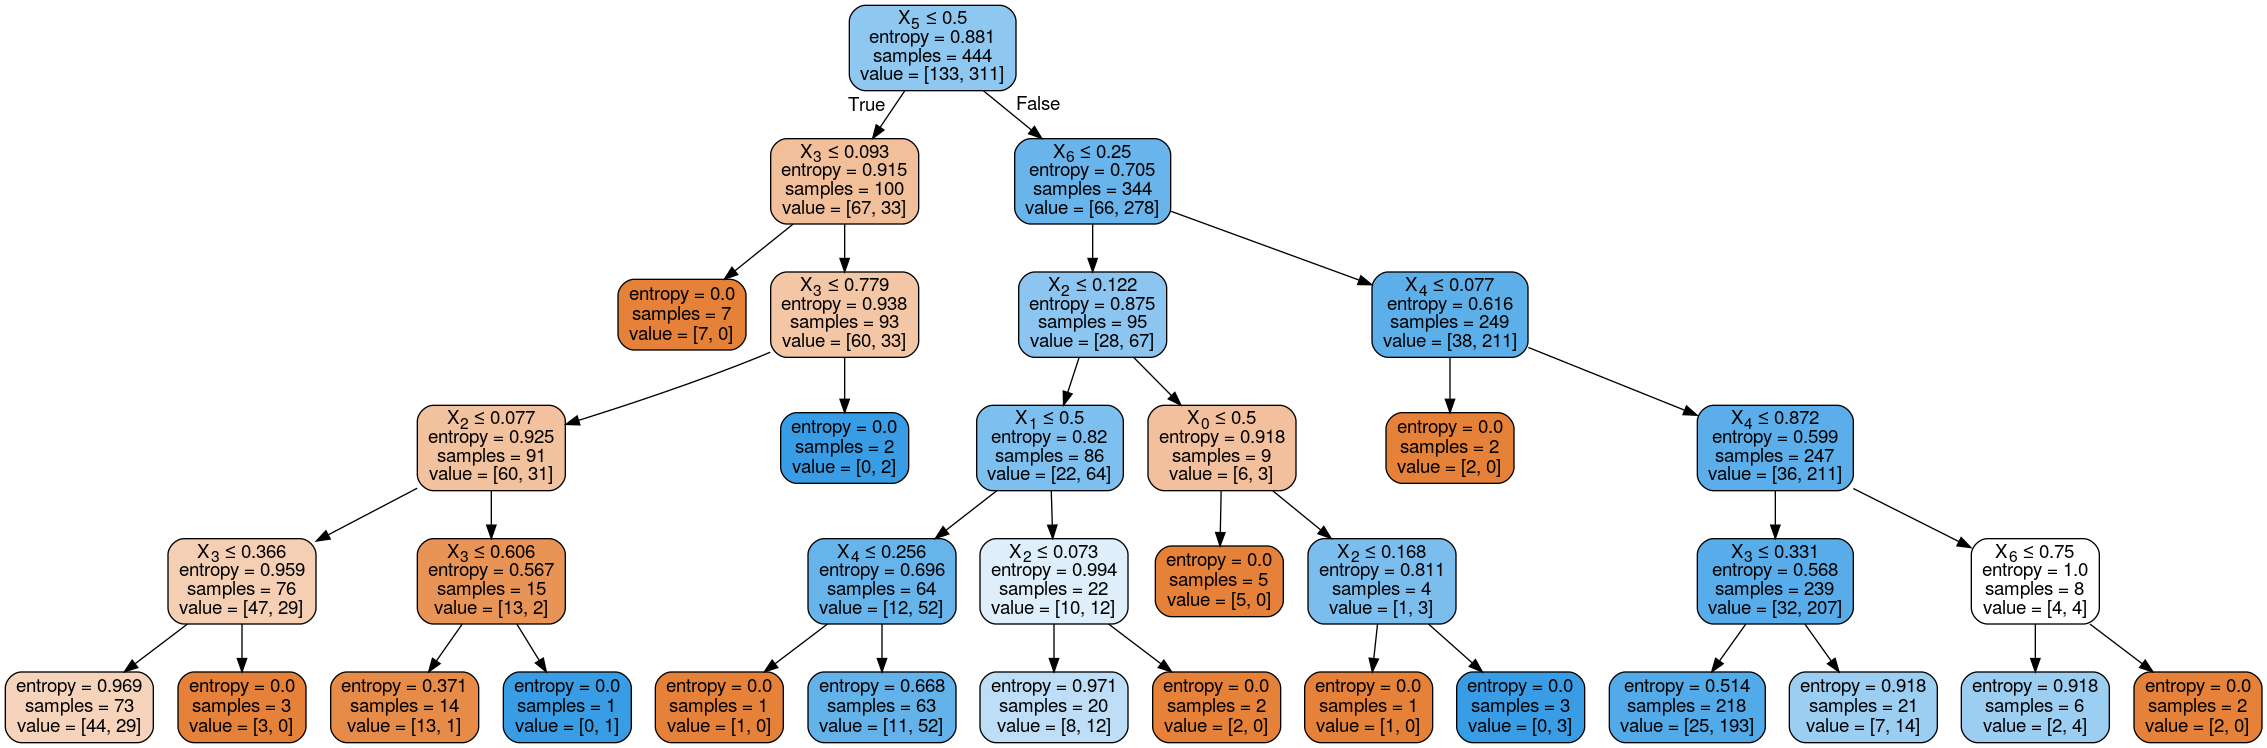

In [223]:
dot_data = StringIO()
tree.export_graphviz(model,out_file=dot_data,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())